In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [13]:
# matplotlib.matplotlib_fname()

In [14]:
# device = torch.device("cuda:1")
device = torch.device("cpu")

## 1D regression dataset

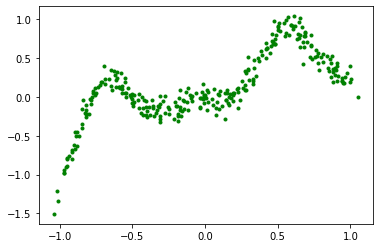

In [15]:
class Dataset2Dregression:
    def __init__(self):
        np.random.seed(12)
        x = np.linspace(0,1,300)
        noise = np.random.normal(0,0.02, x.shape)
        x = x + noise
        x = np.sort(x)

        y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
        noise = np.random.normal(0,0.1, x.shape)
        y = y + noise

        x = x*2
        x = x - x.mean() # good practice to zero-center x in linear mapping
        self.xx = torch.Tensor(x.reshape(-1,1))
        self.yy = torch.Tensor(y.reshape(-1,1))
        self.xy = torch.cat([self.xx, self.yy], dim=-1)
        pass
        
    def sample(self, n):
        assert n <= len(self.xx)
        rand_idx = torch.randperm(len(self.xx))[:n]
        
        return self.xy[rand_idx]

dataset = Dataset2Dregression()
x, y = dataset.xy[:,0], dataset.xy[:,1]

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

## Train Contrastive Model

In [16]:
import dtnnlib as dtnn

In [17]:
class EnergyModel(nn.Module):
    
    def __init__(self, dim, n_components):
        super().__init__()
        self.dt = dtnn.DistanceTransformBase(dim, n_components)
        self.dt.centers.data = torch.rand_like(self.dt.centers)*3-1.5
        
        self.scale = nn.Parameter(torch.zeros(1, n_components))
        
        self.actf = dtnn.OneActiv(n_components, mode='exp_1.6', max_similarity=0)
        
        self.weight = nn.Parameter(torch.randn(n_components, 1))
        
    def forward(self, x):
        self.weight.data = self.weight.data.abs()
#         self.weight.data = self.weight.data / torch.sum(self.weight.data)
        
        x = self.dt(x)
        x = x * torch.exp(self.scale)
        
        x = self.actf(-x)
#         return x.mean(dim=-1, keepdim=True)
        x = x@self.weight
    
#         x = x.mean(dim=-1, keepdim=True)*10 - 5
#         return torch.sigmoid(x-self.weight.data.mean())
        return torch.sigmoid(x-2)

In [18]:
model = EnergyModel(2, 10)
model(torch.randn(5, 2))

tensor([[0.7723],
        [0.1804],
        [0.5217],
        [0.7514],
        [0.4831]], grad_fn=<SigmoidBackward>)

In [19]:
# model.weight

In [20]:
# model = nn.Sequential(
#     nn.Linear(2, 100),
#     nn.ELU(),
#     nn.Linear(100, 1),
#     nn.Sigmoid(),
# )

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [ ]:
exit_plot = None
def start_loop():
    global exit_plot
    exit_plot = False
    
def stop_loop(evt):
    global exit_plot
    exit_plot = True

In [27]:
%matplotlib qt
# plt.ion()
fig = plt.figure()
stop_loop=False
fig.canvas.mpl_connect('close_event', lambda x: stop_loop=True)
ax = fig.add_subplot(111)

N = 200
for i in range(1000):
    xpos = dataset.sample(N)
    ypos = torch.ones(N, 1)
    xneg = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1)
    yneg = torch.zeros(N, 1)
    
    e_pos = model(xpos)
    e_neg = model(xneg)
    
    error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
#     error = (e_pos - e_neg).mean()
    
#     error = (e_pos - e_neg) + 0.1 * (e_pos ** 2 + e_neg ** 2)
#     error = error.mean()
        
    optimizer.zero_grad()
    error.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
    optimizer.step()
    
    if i%100 == 0:
        accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
        print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
        ax.scatter(xneg[:,0], xneg[:,1], marker='.', color='r')
#         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

        fig.canvas.draw()
        fig.canvas.flush_events()
#         plt.pause(0.1)
        time.sleep(0.1)
        ax.clear()
plt.close()



# for i_epoch in range(args.n_epoch):
#     l_loss = []
#     for pos_x, in train_dl:
        
#         pos_x = pos_x.cuda()
        
#         neg_x = torch.randn_like(pos_x)
#         neg_x = sample_langevin(neg_x, model, args.stepsize, args.n_steps, intermediate_samples=False)
        
#         opt.zero_grad()
#         pos_out = model(pos_x)
#         neg_out = model(neg_x)
        
#         loss = (pos_out - neg_out) + args.alpha * (pos_out ** 2 + neg_out ** 2)
#         loss = loss.mean()
#         loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
#         opt.step()
        
#         l_loss.append(loss.item())
#     print(np.mean(l_loss))

SyntaxError: lambda cannot contain assignment (<ipython-input-27-996f2fedbed4>, line 5)

In [23]:
xx, yy = torch.meshgrid([torch.linspace(-1.2, 1.2, 50), torch.linspace(-1.6, 1.1, 50)])
xx.shape, yy.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [24]:
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xxyy = torch.cat([xx, yy], dim=-1)
xxyy.shape

torch.Size([2500, 2])

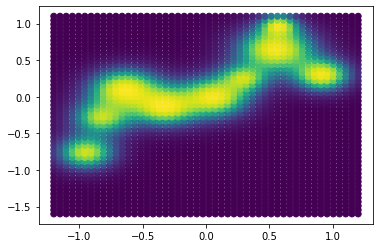

In [16]:
out = model(xxyy).data

%matplotlib inline
plt.scatter(xxyy[:,0], xxyy[:,1], c=out.reshape(-1))

In [17]:
asdfdsf

NameError: name 'asdfdsf' is not defined

### Optimize for best Y given the X

In [18]:
x = dataset.xy[:,:1]
# y = torch.autograd.Variable(torch.zeros_like(x), requires_grad=True)
y = torch.autograd.Variable(torch.randn_like(x)*0.3, requires_grad=True)

In [19]:
xy = torch.cat([x, y], dim=-1)
xy.requires_grad

True

In [20]:
optimizer = optim.Adam([y], lr=0.001)

In [22]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(1000):
    xy = torch.cat([x, y], dim=-1)
    error = -model(xy).mean()
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, E: {error:.6f}")
        
        ax.clear()
        ax.scatter(x, y.data, marker='.', color='r')
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: -0.919816
Step: 100, E: -0.919840
Step: 200, E: -0.919847
Step: 300, E: -0.919849
Step: 400, E: -0.919850
Step: 500, E: -0.919850
Step: 600, E: -0.919850
Step: 700, E: -0.919850
Step: 800, E: -0.919850
Step: 900, E: -0.919850


In [23]:
y.grad

tensor([[ 2.7940e-09],
        [ 6.5193e-09],
        [ 0.0000e+00],
        [-5.5879e-09],
        [ 9.3132e-09],
        [ 9.3132e-09],
        [-3.7253e-09],
        [ 9.3132e-09],
        [ 5.5879e-09],
        [-9.3132e-09],
        [-1.4901e-08],
        [ 1.1176e-08],
        [ 9.3132e-09],
        [-3.7253e-09],
        [-1.8626e-09],
        [ 5.5879e-09],
        [ 3.7253e-09],
        [ 1.1176e-08],
        [ 5.5879e-09],
        [ 1.8626e-09],
        [ 7.4506e-09],
        [-1.3039e-08],
        [ 5.5879e-09],
        [ 5.5879e-09],
        [-1.8626e-08],
        [-6.9849e-10],
        [-2.6077e-08],
        [-7.4506e-09],
        [ 2.3283e-10],
        [ 0.0000e+00],
        [-1.6764e-08],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 7.4506e-09],
        [ 4.6566e-09],
        [-3.7253e-09],
        [-7.4506e-09],
        [ 4.6566e-10],
        [ 9.3132e-10],
        [-4.6566e-10],
        [-3.5297e-07],
        [ 1

In [24]:
# %matplotlib inline
# plt.scatter(x, y, marker='.', color='g')
# plt.scatter(x, YY.data, marker='.', color='r')
# plt.show()

## Multi-Layered Energy Based Model

In [519]:
class LayeredEnergyModel(nn.Module):
    
    def __init__(self, dim, n_components):
        super().__init__()
        self.dim = dim
        self.n_components = n_components
        
        self.scale_x = nn.Parameter(torch.zeros(1, dim))

        self.dt = dtnn.DistanceTransformBase(dim, n_components)
        self.dt.centers.data = torch.rand_like(self.dt.centers)*3-1.5
        
        self.scale_y = nn.Parameter(torch.zeros(1, n_components))
        
        self.actf = dtnn.OneActiv(n_components, mode='exp_1.6', max_similarity=0)
        
        self.weight = nn.Parameter(torch.randn(n_components, 1))
        
        self.init = False
        
    def forward(self, x):
        ## Initialize to random data at first forward
        if not self.init:
            print("Centers Initialized")
#             print(self.dt.centers.data.shape)
#             print(x[torch.randperm(len(x))[:self.n_components]].shape)
            self.dt.centers.data = x[torch.randperm(len(x))[:self.n_components]]
            self.init = True
            
        x = x * torch.exp(self.scale_x)
        x = self.dt(x)
        x = x * torch.exp(self.scale_y)
        
#         x = self.actf(-x)
        return x

    def energy(self, x):
        self.weight.data = self.weight.data.abs()
#         self.weight.data = self.weight.data / torch.sum(self.weight.data)
        
#         x = x * torch.exp(self.scale_x)
#         x = self.dt(x)
#         x = x * torch.exp(self.scale_y)
        x = self.forward(x)
    
        x = self.actf(-x)
        
        x = x@self.weight
        
#         x = x.mean(dim=-1, keepdim=True)*10 - 5
        return torch.sigmoid(x-2)

In [539]:
Nl1 = 3

In [540]:
layer_1 = LayeredEnergyModel(2, Nl1)

In [541]:
optimizer = optim.Adam(layer_1.parameters(), lr=0.005)
criterion = nn.BCELoss()

In [542]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

N = 200
for i in range(2000):
    xpos = dataset.sample(N)
    ypos = torch.ones(N, 1)
    xneg = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1)
    yneg = torch.zeros(N, 1)
    
    e_pos = layer_1.energy(xpos)
    e_neg = layer_1.energy(xneg)
    
    error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
    optimizer.zero_grad()
    error.backward()
    torch.nn.utils.clip_grad_norm_(layer_1.parameters(), max_norm=1)
    optimizer.step()
    
    if i%100 == 0:
        accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
        print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
        ax.clear()
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
        ax.scatter(xneg[:,0], xneg[:,1], marker='.', color='r')
#         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Centers Initialized
Step: 0, E: 1.352707, Acc: 0.5649999976158142
Step: 100, E: 1.045263, Acc: 0.7849999666213989
Step: 200, E: 0.999266, Acc: 0.7925000190734863
Step: 300, E: 0.948664, Acc: 0.7975000143051147
Step: 400, E: 0.914040, Acc: 0.809999942779541
Step: 500, E: 0.896486, Acc: 0.8274999856948853
Step: 600, E: 0.879824, Acc: 0.8274999856948853
Step: 700, E: 0.875662, Acc: 0.8274999856948853
Step: 800, E: 0.807931, Acc: 0.8550000190734863
Step: 900, E: 0.921674, Acc: 0.8100000023841858
Step: 1000, E: 0.835446, Acc: 0.8574999570846558
Step: 1100, E: 0.768268, Acc: 0.875
Step: 1200, E: 0.746612, Acc: 0.8675000071525574
Step: 1300, E: 0.822492, Acc: 0.8474999666213989
Step: 1400, E: 0.788678, Acc: 0.8700000047683716
Step: 1500, E: 0.810238, Acc: 0.8600000143051147
Step: 1600, E: 0.842853, Acc: 0.8374999761581421
Step: 1700, E: 0.848710, Acc: 0.8500000238418579
Step: 1800, E: 0.742142, Acc: 0.8799999952316284
Step: 1900, E: 0.773403, Acc: 0.862500011920929


In [543]:
xx, yy = torch.meshgrid([torch.linspace(-1.2, 1.2, 50), torch.linspace(-1.6, 1.1, 50)])
xx.shape, yy.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [544]:
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xxyy = torch.cat([xx, yy], dim=-1)
xxyy.shape

torch.Size([2500, 2])

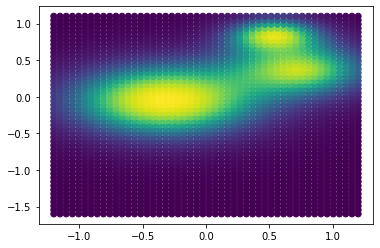

In [545]:
out = layer_1.energy(xxyy).data

%matplotlib inline
plt.scatter(xxyy[:,0], xxyy[:,1], c=out.reshape(-1))

#### Add layer 2 of Energy Model

In [546]:
Nl2 = 10
layer_2 = LayeredEnergyModel(Nl1+2, Nl2)
# layer_2 = LayeredEnergyModel(21, 20)

In [547]:
optimizer = optim.Adam(layer_2.parameters(), lr=0.005)

criterion = nn.BCELoss()

In [548]:
def generate_uniform_negative(xpos, padding_ratio=0.2):
    n = torch.rand_like(xpos)
    pmin, pmax = xpos.min(dim=0, keepdim=True)[0], xpos.max(dim=0, keepdim=True)[0]
    
    pmin = pmin - padding_ratio
    pmax = pmax + padding_ratio
    
    n = n*(pmax-pmin)
    n = n+pmin
    return n

generate_uniform_negative(torch.Tensor([[-1],[1]]))

tensor([[0.6075],
        [1.0084]])

In [549]:
# %matplotlib tk
# fig = plt.figure()
# ax = fig.add_subplot(111)

# N = 200
# for i in range(2000):
#     with torch.no_grad():
#         xpos_0 = dataset.sample(N)
#         xneg_0 = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1)

#         ### Using both x and y
#         xpos, xneg = xpos_0, xneg_0
# #         ?? should layer 2 have new random x ? -> maybe no; because its energy for same x
# #         xneg = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1) 
        
#         ### Using only y
# #         xpos = xpos_0[:, 1:]
# #         xneg = torch.rand(N,1)*3-1.7
        
#         xpos = torch.cat([xpos, layer_1(xpos_0)], dim=-1)
        
#         ### both values of xneg are valid (combining might be better)
# #         xneg = torch.cat([xneg, layer_1(xneg_0)], dim=-1)
# #         xneg = torch.cat([xneg, layer_1(xpos_0)], dim=-1)
#         ### combining using random interpolation
#         alpha = torch.rand(len(xneg_0), 1)
#         xneg = torch.cat([xneg, layer_1(xneg_0)*alpha + (1-alpha)*layer_1(xpos_0)], dim=-1)
#         xneg = torch.cat([xneg, ], dim=-1)

    
    
#     ypos = torch.ones(N, 1)
#     yneg = torch.zeros(N, 1)
    
#     e_pos = layer_2.energy(xpos)
#     e_neg = layer_2.energy(xneg)
    
#     error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
#     optimizer.zero_grad()
#     error.backward()
#     torch.nn.utils.clip_grad_norm_(layer_2.parameters(), max_norm=1)
#     optimizer.step()
    
#     if i%100 == 0:
#         accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
#         print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
#         ax.clear()
#         ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
#         ax.scatter(xneg_0[:,0], xneg_0[:,1], marker='.', color='r')
# #         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

#         fig.canvas.draw()
#         plt.pause(0.01)
# plt.close()

In [550]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

N = 200
for i in range(2000):
    with torch.no_grad():
        xpos_0 = dataset.sample(N)
        xneg_0 = generate_uniform_negative(xpos_0)
        
        hpos_1 = layer_1(xpos_0)
#         hneg_1 = layer_1(generate_uniform_negative(xpos_0))
        hneg_1 = layer_1(xneg_0)

        ### Using both x and y
        inp = xpos_0
        ### Using only y
#         inp = xpos_0[:, 1:]
        
        ## What is positive is valid xy and its representation 
        xpos_1 = torch.cat([inp, hpos_1], dim=-1)

        ## Use random like for second layer => treat it same as first layer
        xneg_1 = generate_uniform_negative(xpos_1)
        ## Use x-neg_0 + h-neg_1 => Teach it what is noise in Input Layer + X-noise in second layer
#         xnet_1 = torch.cat([generate_uniform_negative(inp), hneg_1], dim=-1)
#         xnet_1 = torch.cat([xneg_0, hneg_1], dim=-1)
        ## Use x-neg_0 + h-pos_1 => Teach it what is noise in Input Layer when signals don't match.
#         xneg_1 = torch.cat([generate_uniform_negative(inp), hpos_1], dim=-1)
#         xneg_1 = torch.cat([xneg_0, hpos_1], dim=-1)


        xneg, xpos = xneg_1, xpos_1
#         print(hpos_1.shape, xpos_1.shape)
    
    
    ypos = torch.ones(N, 1)
    yneg = torch.zeros(N, 1)
    
    e_pos = layer_2.energy(xpos)
    e_neg = layer_2.energy(xneg)
    
    error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
    optimizer.zero_grad()
    error.backward()
    torch.nn.utils.clip_grad_norm_(layer_2.parameters(), max_norm=1)
    optimizer.step()
    
    if i%100 == 0:
        accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
        print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
        ax.clear()
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
        ax.scatter(xneg_0[:,0], xneg_0[:,1], marker='.', color='r')
#         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Centers Initialized
Step: 0, E: 0.768105, Acc: 0.7925000190734863
Step: 100, E: 0.506405, Acc: 0.9399999976158142
Step: 200, E: 0.373265, Acc: 0.9750000238418579
Step: 300, E: 0.309906, Acc: 0.9775000214576721
Step: 400, E: 0.303646, Acc: 0.9750000238418579
Step: 500, E: 0.281209, Acc: 0.9825000166893005
Step: 600, E: 0.279190, Acc: 0.9750000238418579
Step: 700, E: 0.271309, Acc: 0.9800000190734863
Step: 800, E: 0.252682, Acc: 0.987500011920929
Step: 900, E: 0.246050, Acc: 0.9800000190734863
Step: 1000, E: 0.269377, Acc: 0.9750000238418579
Step: 1100, E: 0.210151, Acc: 0.9925000071525574
Step: 1200, E: 0.212931, Acc: 0.9900000095367432
Step: 1300, E: 0.211546, Acc: 0.9900000095367432
Step: 1400, E: 0.205259, Acc: 0.9950000047683716
Step: 1500, E: 0.243888, Acc: 0.9750000238418579
Step: 1600, E: 0.232559, Acc: 0.987500011920929
Step: 1700, E: 0.190727, Acc: 0.9925000071525574
Step: 1800, E: 0.212697, Acc: 0.9850000143051147
Step: 1900, E: 0.226654, Acc: 0.9900000095367432


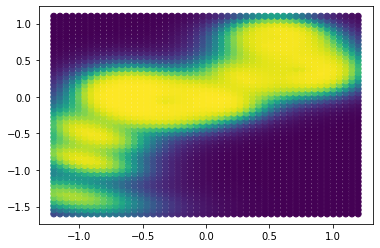

In [551]:
data = torch.cat([xxyy, layer_1(xxyy)], dim=-1)
# data = torch.cat([xxyy[:,1:], layer_1(xxyy)], dim=-1)
out = layer_2.energy(data).data

%matplotlib inline
plt.scatter(xxyy[:,0], xxyy[:,1], c=out.reshape(-1))

### Optimize for best Y given the X

In [552]:
x = dataset.xy[:,:1]
# y = torch.autograd.Variable(torch.zeros_like(x), requires_grad=True)
y = torch.autograd.Variable(torch.randn_like(x)*0.3, requires_grad=True)

In [553]:
# xy = torch.cat([x, y], dim=-1)
# xy.requires_grad

In [554]:
optimizer = optim.Adam([y], lr=0.01)

In [557]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(2000):
    out = 0
####################################3
    xy = torch.cat([x, y], dim=-1)
    out = layer_1.energy(xy) + out
####################################3
#     with torch.no_grad():
#         e1 = layer_1(xy).data

    ## use xy=xy for both x and y
    xy = torch.cat([xy, layer_1(xy).data], dim=-1)
    ## for only y
#     xy = torch.cat([y, e1], dim=-1)

    out = layer_2.energy(xy) + out
####################################3

    error = -out.mean()
    
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, E: {error:.6f}")
        
        ax.clear()
        ax.scatter(x, y.data, marker='.', color='r')
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: -1.794022
Step: 100, E: -1.803450
Step: 200, E: -1.803442
Step: 300, E: -1.803443
Step: 400, E: -1.803443
Step: 500, E: -1.803443
Step: 600, E: -1.803442
Step: 700, E: -1.803443
Step: 800, E: -1.803443
Step: 900, E: -1.803443
Step: 1000, E: -1.803442
Step: 1100, E: -1.803442
Step: 1200, E: -1.803443
Step: 1300, E: -1.803442
Step: 1400, E: -1.803442
Step: 1500, E: -1.803443
Step: 1600, E: -1.803443
Step: 1700, E: -1.803443
Step: 1800, E: -1.803443
Step: 1900, E: -1.803443


In [343]:
layer_1.dt.centers.shape

torch.Size([20, 2])

## Need to conduct which x-neg is the best for next layer

- Multiple possibilities; can even combine all.
- Need to find which methods produce the best energy model.
- Current energy model is My != Energy models in Literature. (Is metric the key ?
- Use normalization and softmax (Group-Softmax for parallelization) to control the distribution of the neurons firing.